In [9]:
# 30 May 2022

In [21]:
import numpy as np 
import matplotlib.pyplot as plt
import time
import cv2
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import open_gym_buoy_with_wind as oceangym
from importlib import reload

In [22]:
import open_gym_buoy_with_wind as oceangym

self.canvas_size=array([300, 300]) self.grid_width=50 self.wind_grid_shape=array([6, 6])
******************************
self.wind_grid_shape=array([6, 6]), self.grid_width=50

!------- generated random wind ---!
self.wind_x_grid.shape=(6, 6)
self.wind_x_grid.shape=(6, 6)
self.xx.shape=(6, 6)

plotted wind img in init
******************************
self.wind_grid_shape=array([6, 6]), self.grid_width=50

!------- generated random wind ---!
self.wind_x_grid.shape=(6, 6)
self.wind_x_grid.shape=(6, 6)
self.xx.shape=(6, 6)

drwaing wind boundaries
done drawing elements on canvas
hurray! in goal region (231, 190), posit 204, 190, dist 27.0
reached goal, final return 49.689279379186445


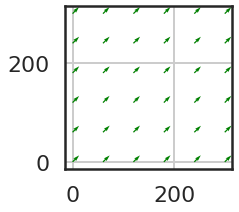

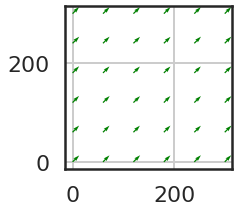

In [23]:
reload(oceangym)
env = oceangym.OceanScape()
obs = env.reset()

while True:
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    # Render the game
    env.render()
    #plt.show()

    if done == True:
        cv2.waitKey(0)
        break

env.close()

In [24]:
import seaborn as sns

xvals [[-0.80116398  0.90567605  0.64694835 -0.13351446  0.7934296   0.77448431]
 [ 0.88914234  0.83527931 -0.46074649 -0.35528199 -0.34434023 -0.72540362]
 [-0.22017034 -0.66121882 -0.81570941 -0.48984482 -0.80064146  0.13503604]
 [-0.37950912 -0.10031235  0.75433609  0.60122387  0.44109538  0.89641623]
 [-0.3435538  -0.32116757 -0.78131097  0.73226683 -0.38353663  0.39415223]
 [-0.32727577 -0.72392912  0.09816989  0.51647894 -0.71000195 -0.31248466]]
x [0.5 1.5 2.5 3.5 4.5 5.5]


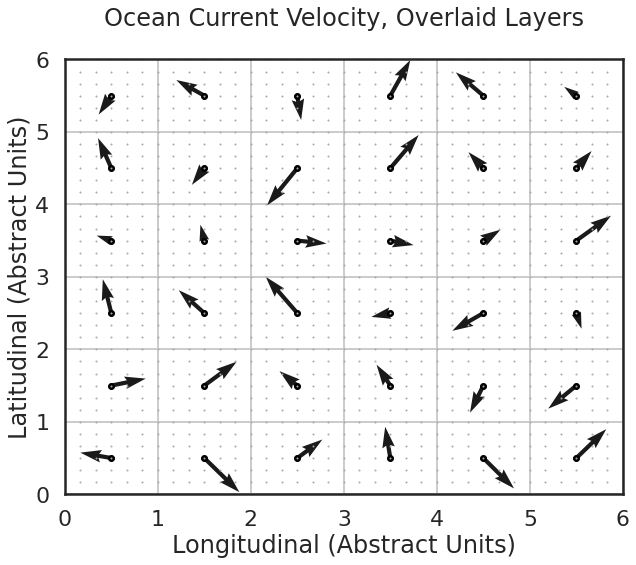

In [36]:
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style='white', context='poster')

plt.figure(figsize=(10,8))
x, y, u, v = np.random.random((4,10))
#xvals = np.random.random((6,6))
#yvals = np.random.random((6,6))
xvals = np.random.uniform(-1, 1, (6,6)) * .98
yvals = np.random.uniform(-1, 1, (6,6)) * .98
print('xvals', xvals)

x = np.linspace(0.5, 5.5, 6)  # uhm. get 6 values
y = np.linspace(0.5, 5.5, 6) 
print('x', x)
xx, yy = np.meshgrid(x, y) 
xx, yy = np.meshgrid(x, y)  # these are all the arrows

plt.quiver(xx, yy, xvals, yvals,)
plt.plot(xx, yy, 'o', color='black', markersize='6')

plt.title('Ocean Current Velocity, Overlaid Layers\n')
plt.ylabel('Latitudinal (Abstract Units)')
plt.xlabel('Longitudinal (Abstract Units)')
plt.xlim(0, 300/50)
plt.ylim(0, 300/50)
plt.grid(True)

#--- Now add dot grid.
x = np.linspace(0.0, 6, 37)  # uhm. get 6 values
y = np.linspace(0.0, 6, 37) 
XX, YY = np.meshgrid(x,y)
plt.plot(XX.flat, YY.flat, ".", color='darkgray', markersize='2')

#plt.savefig('./wind_vectors_2.png',  transparent=True)
plt.show()

In [ ]:
# now add in some lines

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import matplotlib.colors as mcolors 

from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# MAKE INTO FUNCTION

In [247]:
a = {'a':3123}
a.b = 'asdf'
a

AttributeError: 'dict' object has no attribute 'b'

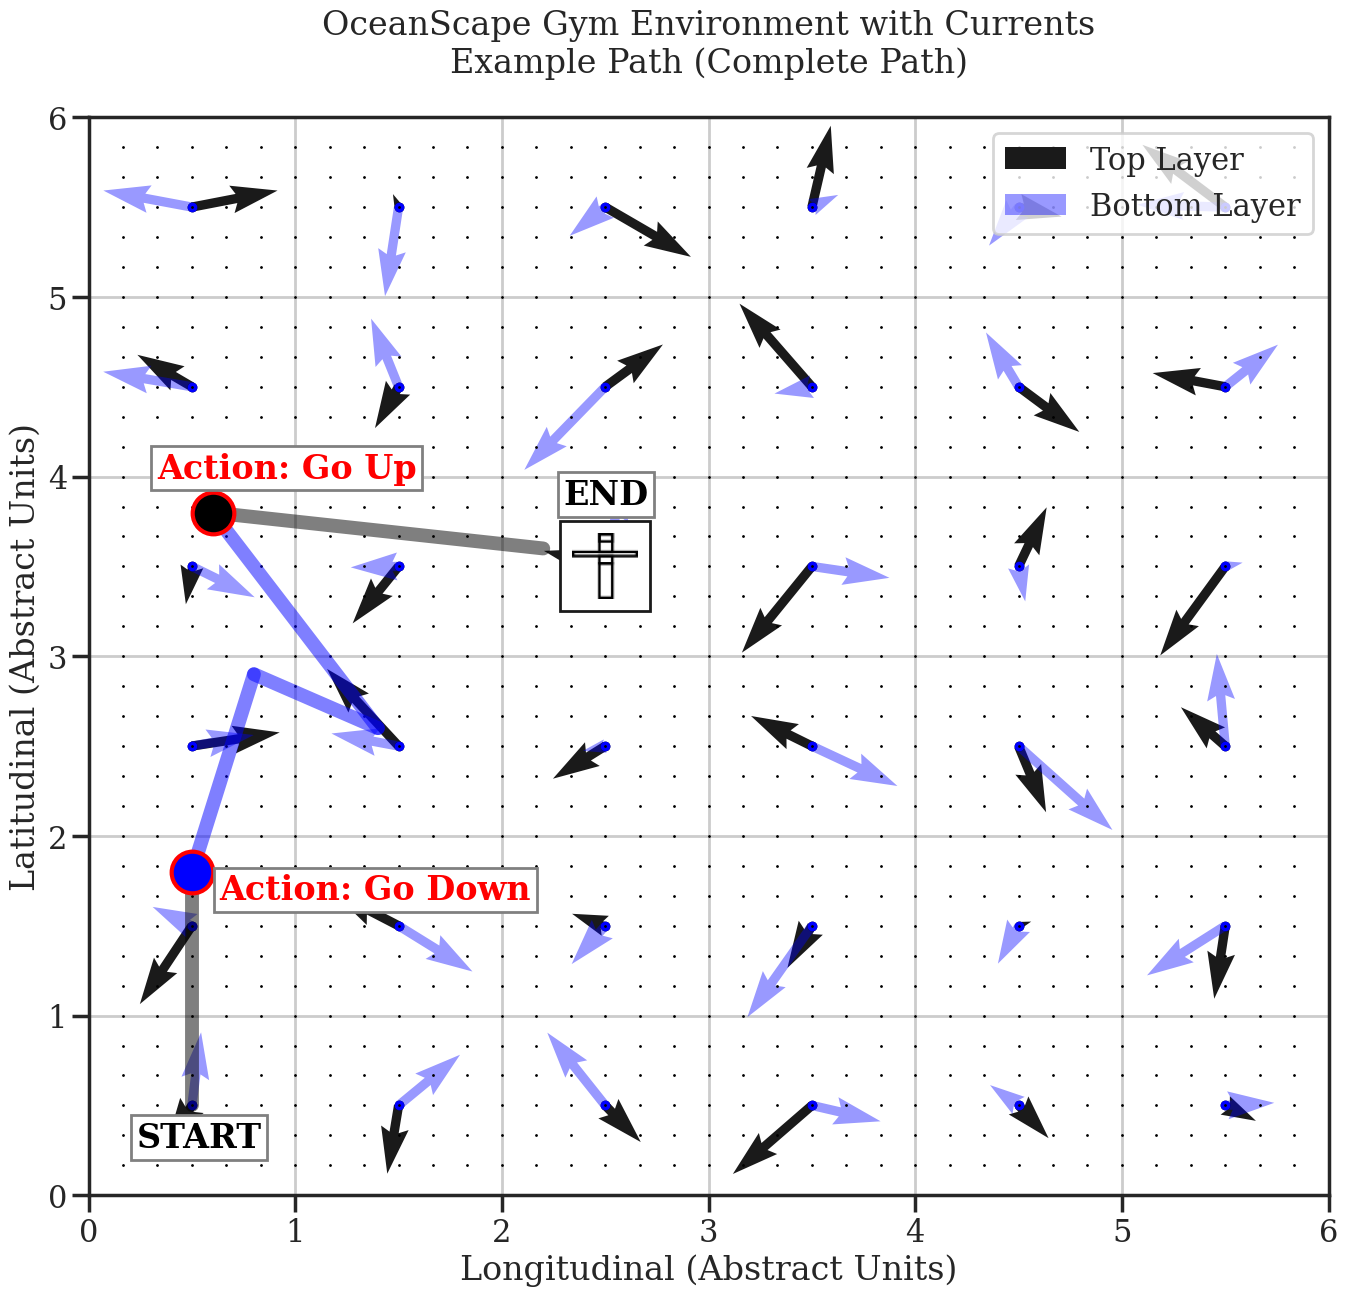

********************************************************************************
end plot
********************************************************************************


In [278]:
sns.reset_defaults()
sns.set_theme(style='ticks', context='poster')
plt.rcParams.update({
"font.family": "Dejavu Serif",
}) 

from numpy.random import RandomState, SeedSequence
from numpy.random import MT19937
rs = RandomState(MT19937(SeedSequence(0)))
np.random.seed(0)

fig = plt.figure(figsize=(16,14))

# Plots:
# No path
  # Overlaid
  # And subplots of separate
# With path
  # Overlaid
  # And subplots of separate


major_grid = False
bullet_journal = False 

plot_arrows_black = False
plot_arrows_blue = False
plot_graph_labels = False

define_path = False
plot_path_black = False

plot_path_blue = False

plot_path_dots = False
plot_start_end_buoy = False

plot_legend = False

filename = 'opengym_report_plot'
save_fig = False
set_aspect_equal = False 
plot_annotations_start_end_buoy = False


# -- always want these
bullet_journal = True
major_grid = True
plot_graph_labels = True
define_path = True

ARROWS = False
BLACK = False
BLUE = False
PATH = False

# ---- BEGIN 
save_fig = True
title_str = 'OceanScape Gym Environment with Currents\n'
title_str += 'Top Layer\n'
plot_filename = 'top_arrows.svg' 
ARROWS = True 
BLACK = True 
BLUE = False
PATH = False

save_fig = True
plot_filename = 'bottom_arrows.svg' 
title_str = 'OceanScape Gym Environment with Currents\n'
title_str += 'Bottom Layer\n'
ARROWS = True 
BLACK = False 
BLUE = True 
PATH = False

save_fig = True
plot_filename = 'both_arrows.svg' 
title_str = 'OceanScape Gym Environment with Currents\n'
title_str += 'Overlaid Layers\n'
ARROWS = True 
BLACK = True
BLUE = True 
PATH = False


PATHS = [1, # first black
        2, # add in blue
        3] # add black and goal
# -- add in path
'''
save_fig = True
plot_filename = 'path1.svg' 
title_str = 'OceanScape Gym Environment with Currents\n'
title_str += 'Example Path, Top Layer\n'
ARROWS = True 
BLACK = True 
BLUE = False 
PATH = [1,2]

save_fig = True
plot_filename = 'bottom_path.svg' 
title_str = 'OceanScape Gym Environment with Currents\n'
title_str += 'Example Path, Top Layer (Blue)\n'
ARROWS = True 
BLACK = False 
BLUE = True 
PATH = True 
'''
save_fig = True
plot_filename = 'finalpath.svg' 
title_str = 'OceanScape Gym Environment with Currents\n'
title_str += 'Example Path (Complete Path)\n'
ARROWS = True 
BLACK = True 
BLUE = True 
PATH = True 




if ARROWS:
    if BLACK:
        plot_arrows_black = True
    if BLUE: 
        plot_arrows_blue = True
    plot_legend = True

if PATH:
    define_path = True
    if BLACK:
        plot_path_black = True
        plot_path_dots = True
        plot_start_end_buoy = True
        plot_annotations_start_end_buoy = True
    if BLUE:
        plot_path_blue = True
    plot_path_dots = True
    plot_legend = True

# -------------------------------------
if  plot_arrows_black:
        # -- plot random arrows
        x, y, u, v = np.random.random((4,10), )
        xvals = np.random.uniform(-1, 1, (6,6)) * .98
        yvals = np.random.uniform(-1, 1, (6,6)) * .98

        x = np.linspace(0.5, 5.5, 6)  # uhm. get 6 values
        y = np.linspace(0.5, 5.5, 6) 
        xx, yy = np.meshgrid(x, y) 
        xx, yy = np.meshgrid(x, y)  # these are all the arrows

        plt.quiver(xx, yy, xvals, yvals, label='Top Layer')
        plt.plot(xx, yy, 'o', color='black', markersize='6')

if  plot_arrows_blue:
        # -- plot random arrows
        np.random.seed(10)
        x, y, u, v = np.random.random((4,10), )
        xvals = np.random.uniform(-1, 1, (6,6)) * .98
        yvals = np.random.uniform(-1, 1, (6,6)) * .98

        x = np.linspace(0.5, 5.5, 6)  # uhm. get 6 values
        y = np.linspace(0.5, 5.5, 6) 
        xx, yy = np.meshgrid(x, y) 
        xx, yy = np.meshgrid(x, y)  # these are all the arrows

        plt.quiver(xx, yy, xvals, yvals,color='blue', alpha=0.4, label='Bottom Layer')
        plt.plot(xx, yy, 'o', color='blue', markersize='6')
        #----

if plot_graph_labels:
    #plt.title('OceanScape Gym with Currents,\nOverlaid Layers\n')
    plt.title(title_str)
    plt.ylabel('Latitudinal (Abstract Units)')
    plt.xlabel('Longitudinal (Abstract Units)')
    plt.xlim(0, 300/50)
    plt.ylim(0, 300/50)

if bullet_journal:
    #--- Now add dot grid.
    x = np.linspace(0.0, 6, 37)  # uhm. get 6 values
    y = np.linspace(0.0, 6, 37) 
    XX, YY = np.meshgrid(x,y)
    plt.plot(XX.flat, YY.flat, ".", color='black', markersize='2')

if define_path:
    # xdata, ydata
    xs = [
        (0.5, 0.5),
        (0.5, 0.8), #L1
        (0.8, 1.4),
        (1.4, 0.6),
        (0.6, 2.2)
    ]
    ys = [
        (0.5, 1.8),
        (1.8, 2.9),
        (2.9, 2.6),
        (2.6, 3.8),
        (3.8, 3.6)
    ]
    # blues = [1,2,3]#L2, L3, L4
    # blacks = [0, 4]

    SCALE = 1
    x_blues = np.array([xs[1], xs[2], xs[3]]) * SCALE
    y_blues = np.array([ys[1], ys[2], ys[3]]) * SCALE

    x_blacks = np.array([xs[0], xs[4]]) * SCALE
    y_blacks = np.array([ys[0], ys[4]]) * SCALE

# -- matplotlib is a mess - define fxn to add lines at correct scale
def newline(p1, p2, color='red', opacity=1.0):
    LINE_WIDTH=10
    color = mcolors.to_rgba(color)
    color = color * np.array((1,1,1,opacity))

    ax = plt.gca()
    l = mlines.Line2D(p1, p2, color=color, 
                linewidth=LINE_WIDTH, 
                )
    ax.add_line(l)
    return l

OPACITY = 0.5
#--- add the path lines 
if plot_path_black:
    for x,y in zip( x_blacks, y_blacks):
        newline(x,y, color='black', opacity=OPACITY)
if plot_path_blue:
    for x,y in zip( x_blues, y_blues):
        newline(x,y, color='blue', opacity=OPACITY)

if plot_path_dots:
    #--- Now dots for going up/down
    dots_x, dots_y = [0.5, 0.6], [1.8, 3.8]
    ax = plt.gca()
    P1 = ax.plot(dots_x[0], dots_y[0], 
        color='blue', markersize='30', 
        marker='o',
        markeredgecolor='red', markeredgewidth=3)
    P2 = ax.plot(dots_x[1], dots_y[1], 
        color='black', markersize='30',
        marker='o',
        markeredgecolor='red', markeredgewidth=3)

    plt.annotate('Action: Go Down',
            xy=(dots_x[0], dots_y[0]),
            xytext=(20, -20),
            color='red',
            textcoords='offset points',
            fontweight='bold',
                        bbox=dict( ec=(.5,.5,.5), fc=(1,1,1),
                ))

    plt.annotate('Action: Go Up',
            xy=(dots_x[1], dots_y[1]),
            xytext=(-40, 25),
            color='red',
            textcoords='offset points',
            fontweight='bold',
                        bbox=dict( ec=(.5,.5,.5), fc=(1,1,1),
                ))

if plot_annotations_start_end_buoy:
    plt.annotate('START',
            xy=(0.5,0.5),
            xytext=(-40, -30),
            color='black',
            textcoords='offset points',
                    fontweight='bold',
                            bbox=dict( ec=(.5,.5,.5), fc=(1,1,1),
                    ))

    plt.annotate('END',
            xy=(2.5, 3.5),
            xytext=(-30, 45),
            color='black',
            textcoords='offset points',
            fontweight='bold',
                        bbox=dict( ec=(.5,.5,.5), fc=(1,1,1),
                ))

    img_buoy = mpimg.imread('argo_buoy.png')
    imagebox = OffsetImage(img_buoy, zoom=0.8)
    ab = AnnotationBbox(imagebox, (2.5, 3.5))
    ax.add_artist(ab)

if major_grid:
    plt.grid()

if plot_legend:
    plt.legend(loc='upper right')

TRANSPARENT=False
if save_fig:
    #plt.savefig('./output_paths.svg', transparent=TRANSPARENT)
    plt.savefig(plot_filename, transparent=TRANSPARENT)
if set_aspect_equal:
    ax.set_aspect('equal')
    plt.tight_layout()
plt.show()

print('*' * 80)
print('end plot')
print('*' * 80)


# Other

In [244]:
d
sns.reset_defaults()
sns.set_theme(style='ticks', context='poster')
plt.rcParams.update({
"font.family": "Dejavu Serif",
}) 

from numpy.random import RandomState, SeedSequence
from numpy.random import MT19937
rs = RandomState(MT19937(SeedSequence(0)))
np.random.seed(0)

fig = plt.figure(figsize=(16,14))

# -- plot random arrows
x, y, u, v = np.random.random((4,10), )
xvals = np.random.uniform(-1, 1, (6,6)) * .98
yvals = np.random.uniform(-1, 1, (6,6)) * .98

x = np.linspace(0.5, 5.5, 6)  # uhm. get 6 values
y = np.linspace(0.5, 5.5, 6) 
xx, yy = np.meshgrid(x, y) 
xx, yy = np.meshgrid(x, y)  # these are all the arrows

plt.quiver(xx, yy, xvals, yvals, label='Layer 1')
plt.plot(xx, yy, 'o', color='black', markersize='6')

#----
# -- plot random arrows
np.random.seed(10)
x, y, u, v = np.random.random((4,10), )
xvals = np.random.uniform(-1, 1, (6,6)) * .98
yvals = np.random.uniform(-1, 1, (6,6)) * .98

x = np.linspace(0.5, 5.5, 6)  # uhm. get 6 values
y = np.linspace(0.5, 5.5, 6) 
xx, yy = np.meshgrid(x, y) 
xx, yy = np.meshgrid(x, y)  # these are all the arrows

plt.quiver(xx, yy, xvals, yvals,color='blue', alpha=0.4, label='Layer 2')
plt.plot(xx, yy, 'o', color='blue', markersize='6')
#----

plt.title('OceanScape Gym with Currents,\nOverlaid Layers\n')
plt.ylabel('Latitudinal (Abstract Units)')
plt.xlabel('Longitudinal (Abstract Units)')
plt.xlim(0, 300/50)
plt.ylim(0, 300/50)

#--- Now add dot grid.
x = np.linspace(0.0, 6, 37)  # uhm. get 6 values
y = np.linspace(0.0, 6, 37) 
XX, YY = np.meshgrid(x,y)
plt.plot(XX.flat, YY.flat, ".", color='black', markersize='2')
'''
# xdata, ydata
xs = [
    (0.5, 0.5),
    (0.5, 0.8), #L1
    (0.8, 1.4),
    (1.4, 0.6),
    (0.6, 2.2)
]
ys = [
    (0.5, 1.8),
    (1.8, 2.9),
    (2.9, 2.6),
    (2.6, 3.8),
    (3.8, 3.6)
]
# blues = [1,2,3]#L2, L3, L4
# blacks = [0, 4]

SCALE = 1
x_blues = np.array([xs[1], xs[2], xs[3]]) * SCALE
y_blues = np.array([ys[1], ys[2], ys[3]]) * SCALE

x_blacks = np.array([xs[0], xs[4]]) * SCALE
y_blacks = np.array([ys[0], ys[4]]) * SCALE


def newline(p1, p2, color='red', opacity=1.0):
    LINE_WIDTH=10
    color = mcolors.to_rgba(color)
    color = color * np.array((1,1,1,opacity))

    ax = plt.gca()
    l = mlines.Line2D(p1, p2, color=color, 
                linewidth=LINE_WIDTH, 
                )
    ax.add_line(l)
    return l

#--- add the path lines 
OPACITY = 0.5
for x,y in zip( x_blues, y_blues):
    newline(x,y, color='blue', opacity=OPACITY)
for x,y in zip( x_blacks, y_blacks):
    newline(x,y, color='black', opacity=OPACITY)

#--- Now dots for going up/down
dots_x, dots_y = [0.5, 0.6], [1.8, 3.8]
ax = plt.gca()
P1 = ax.plot(dots_x[0], dots_y[0], 
    color='blue', markersize='30', 
    marker='o',
    markeredgecolor='red', markeredgewidth=3)
P2 = ax.plot(dots_x[1], dots_y[1], 
    color='black', markersize='30',
    marker='o',
    markeredgecolor='red', markeredgewidth=3)

plt.annotate('Action: Go Down',
        xy=(dots_x[0], dots_y[0]),
        xytext=(20, -20),
        color='red',
        textcoords='offset points',
        fontweight='bold',
                    bbox=dict( ec=(.5,.5,.5), fc=(1,1,1),
            ))

plt.annotate('Action: Go Up',
        xy=(dots_x[1], dots_y[1]),
        xytext=(-40, 25),
        color='red',
        textcoords='offset points',
        fontweight='bold',
                    bbox=dict( ec=(.5,.5,.5), fc=(1,1,1),
            ))



plt.annotate('START',
        xy=(0.5,0.5),
        xytext=(-40, -30),
        color='black',
        textcoords='offset points',
                fontweight='bold',
                         bbox=dict( ec=(.5,.5,.5), fc=(1,1,1),
                   ))


plt.annotate('END',
        xy=(2.5, 3.5),
        xytext=(-30, 45),
        color='black',
        textcoords='offset points',
        fontweight='bold',

                    bbox=dict( ec=(.5,.5,.5), fc=(1,1,1),
            ))


#plt.savefig('./wind_vectors_2.png',  transparent=True)

from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img_buoy = mpimg.imread('argo_buoy.png')
imagebox = OffsetImage(img_buoy, zoom=0.8)
ab = AnnotationBbox(imagebox, (2.5, 3.5))
ax.add_artist(ab)
'''

plt.legend(loc='upper right')
plt.grid()
ax.set_aspect('equal')
plt.savefig('./twolayers_nobuoypath.svg', transparent=False)
plt.tight_layout()
plt.show()

NameError: name 'd' is not defined

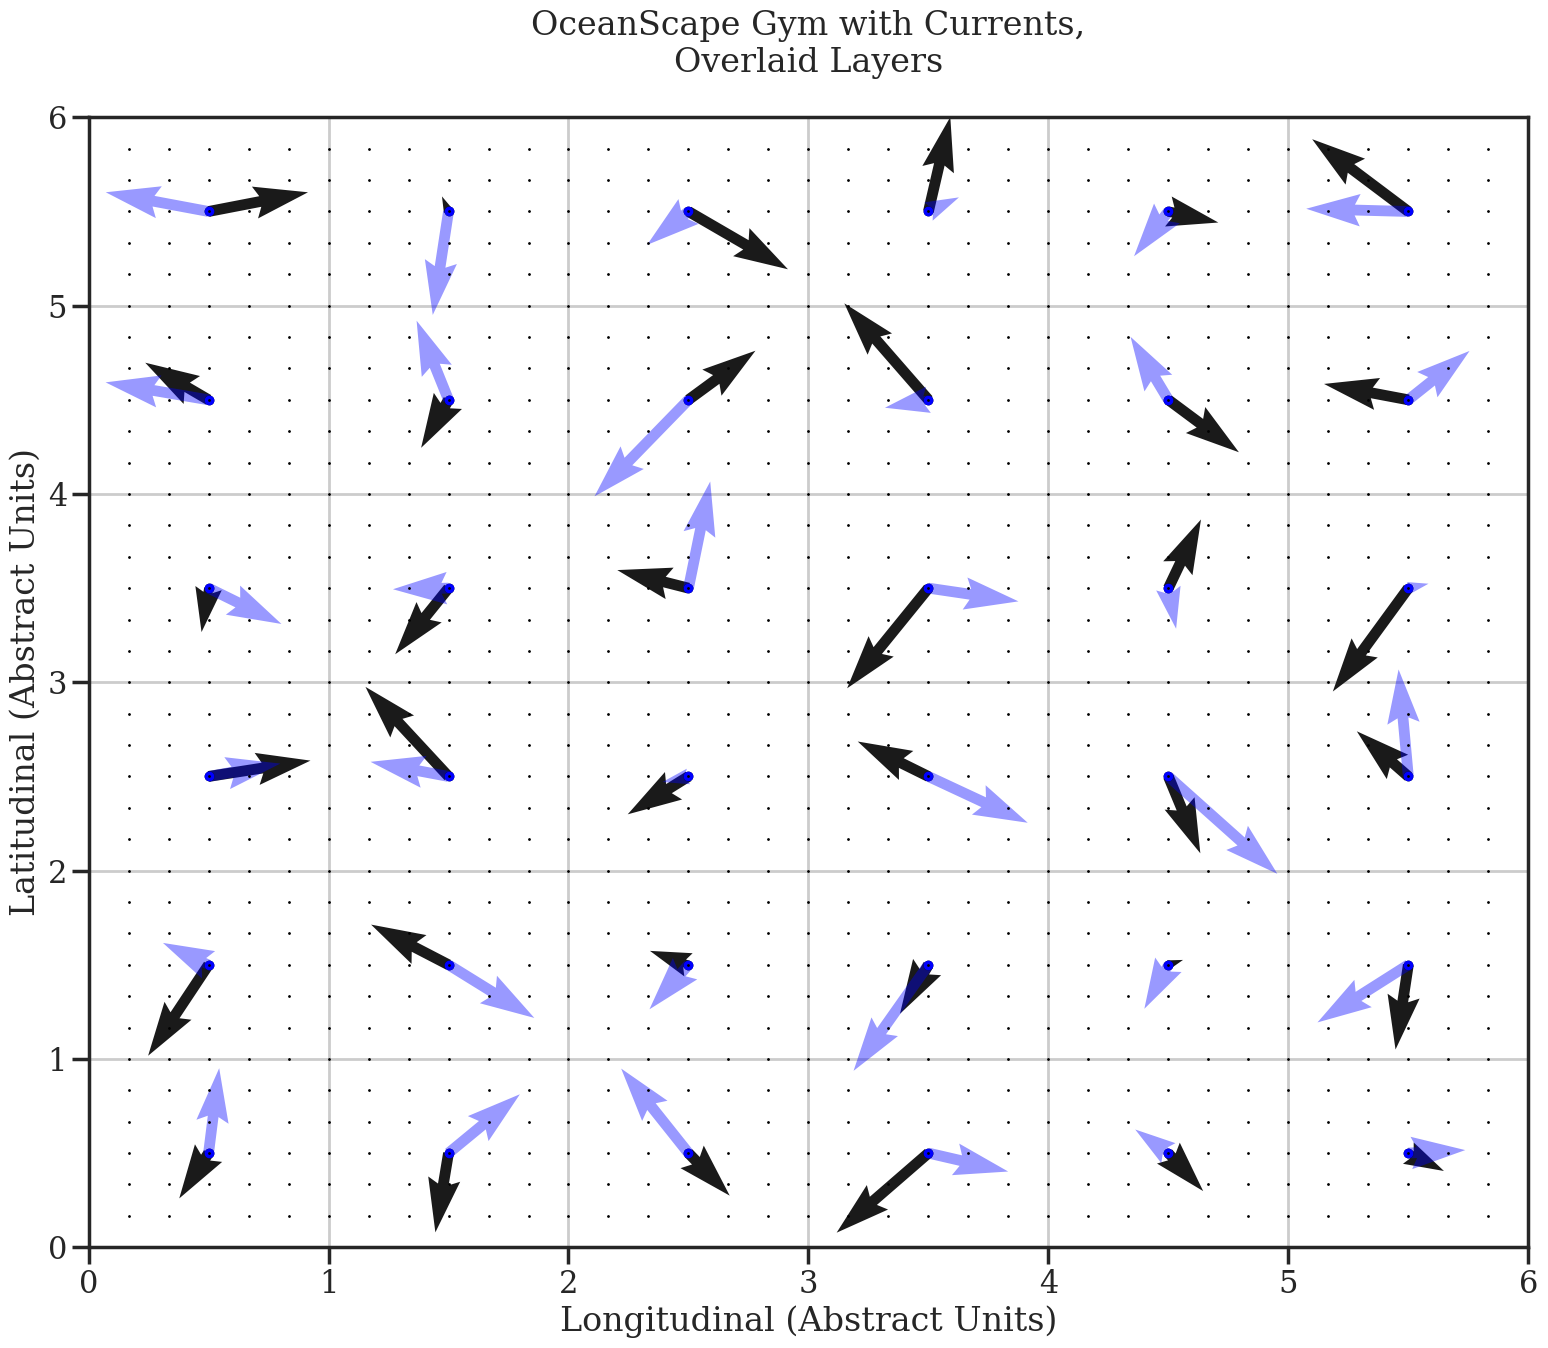

In [ ]:
sns.reset_defaults()
sns.set_theme(style='ticks', context='poster')
plt.rcParams.update({
"font.family": "Dejavu Serif",
}) 

from numpy.random import RandomState, SeedSequence
from numpy.random import MT19937
rs = RandomState(MT19937(SeedSequence(0)))
np.random.seed(0)

fig = plt.figure(figsize=(16,14))

# -- plot random arrows
x, y, u, v = np.random.random((4,10), )
xvals = np.random.uniform(-1, 1, (6,6)) * .98
yvals = np.random.uniform(-1, 1, (6,6)) * .98

x = np.linspace(0.5, 5.5, 6)  # uhm. get 6 values
y = np.linspace(0.5, 5.5, 6) 
xx, yy = np.meshgrid(x, y) 
xx, yy = np.meshgrid(x, y)  # these are all the arrows

plt.quiver(xx, yy, xvals, yvals, label='Layer 1')
plt.plot(xx, yy, 'o', color='black', markersize='6')

'''
#----
# -- plot random arrows
np.random.seed(10)
x, y, u, v = np.random.random((4,10), )
xvals = np.random.uniform(-1, 1, (6,6)) * .98
yvals = np.random.uniform(-1, 1, (6,6)) * .98

x = np.linspace(0.5, 5.5, 6)  # uhm. get 6 values
y = np.linspace(0.5, 5.5, 6) 
xx, yy = np.meshgrid(x, y) 
xx, yy = np.meshgrid(x, y)  # these are all the arrows

plt.quiver(xx, yy, xvals, yvals,color='blue', alpha=0.4, label='Layer 2')
plt.plot(xx, yy, 'o', color='blue', markersize='6')
#----
'''

plt.title('OceanScape Gym with Currents,\nTop Layer\n')
plt.ylabel('Latitudinal (Abstract Units)')
plt.xlabel('Longitudinal (Abstract Units)')
plt.xlim(0, 300/50)
plt.ylim(0, 300/50)

#--- Now add dot grid.
x = np.linspace(0.0, 6, 37)  # uhm. get 6 values
y = np.linspace(0.0, 6, 37) 
XX, YY = np.meshgrid(x,y)
plt.plot(XX.flat, YY.flat, ".", color='black', markersize='2')
'''
# xdata, ydata
xs = [
    (0.5, 0.5),
    (0.5, 0.8), #L1
    (0.8, 1.4),
    (1.4, 0.6),
    (0.6, 2.2)
]
ys = [
    (0.5, 1.8),
    (1.8, 2.9),
    (2.9, 2.6),
    (2.6, 3.8),
    (3.8, 3.6)
]
# blues = [1,2,3]#L2, L3, L4
# blacks = [0, 4]

SCALE = 1
x_blues = np.array([xs[1], xs[2], xs[3]]) * SCALE
y_blues = np.array([ys[1], ys[2], ys[3]]) * SCALE

x_blacks = np.array([xs[0], xs[4]]) * SCALE
y_blacks = np.array([ys[0], ys[4]]) * SCALE


def newline(p1, p2, color='red', opacity=1.0):
    LINE_WIDTH=10
    color = mcolors.to_rgba(color)
    color = color * np.array((1,1,1,opacity))

    ax = plt.gca()
    l = mlines.Line2D(p1, p2, color=color, 
                linewidth=LINE_WIDTH, 
                )
    ax.add_line(l)
    return l

#--- add the path lines 
OPACITY = 0.5
for x,y in zip( x_blues, y_blues):
    newline(x,y, color='blue', opacity=OPACITY)
for x,y in zip( x_blacks, y_blacks):
    newline(x,y, color='black', opacity=OPACITY)

#--- Now dots for going up/down
dots_x, dots_y = [0.5, 0.6], [1.8, 3.8]
ax = plt.gca()
P1 = ax.plot(dots_x[0], dots_y[0], 
    color='blue', markersize='30', 
    marker='o',
    markeredgecolor='red', markeredgewidth=3)
P2 = ax.plot(dots_x[1], dots_y[1], 
    color='black', markersize='30',
    marker='o',
    markeredgecolor='red', markeredgewidth=3)

plt.annotate('Action: Go Down',
        xy=(dots_x[0], dots_y[0]),
        xytext=(20, -20),
        color='red',
        textcoords='offset points',
        fontweight='bold',
                    bbox=dict( ec=(.5,.5,.5), fc=(1,1,1),
            ))

plt.annotate('Action: Go Up',
        xy=(dots_x[1], dots_y[1]),
        xytext=(-40, 25),
        color='red',
        textcoords='offset points',
        fontweight='bold',
                    bbox=dict( ec=(.5,.5,.5), fc=(1,1,1),
            ))



plt.annotate('START',
        xy=(0.5,0.5),
        xytext=(-40, -30),
        color='black',
        textcoords='offset points',
                fontweight='bold',
                         bbox=dict( ec=(.5,.5,.5), fc=(1,1,1),
                   ))


plt.annotate('END',
        xy=(2.5, 3.5),
        xytext=(-30, 45),
        color='black',
        textcoords='offset points',
        fontweight='bold',

                    bbox=dict( ec=(.5,.5,.5), fc=(1,1,1),
            ))


#plt.savefig('./wind_vectors_2.png',  transparent=True)

from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img_buoy = mpimg.imread('argo_buoy.png')
imagebox = OffsetImage(img_buoy, zoom=0.8)
ab = AnnotationBbox(imagebox, (2.5, 3.5))
ax.add_artist(ab)

'''
plt.legend(loc='upper right')
plt.grid()
ax.set_aspect('equal')
plt.savefig('./twolayers_nobuoypath.svg', transparent=False)
plt.tight_layout()
plt.show()

In [20]:
'''
x = np.linspace(0, self.observation_shape[0], self.wind_grid_shape[0]) 
y = np.linspace(0, self.observation_shape[1], self.wind_grid_shape[1]) 

self.xx, self.yy = np.meshgrid(x, y) 
self.xx, self.yy = np.meshgrid(x, y) 
'''

'\nx = np.linspace(0, self.observation_shape[0], self.wind_grid_shape[0]) \ny = np.linspace(0, self.observation_shape[1], self.wind_grid_shape[1]) \n\nself.xx, self.yy = np.meshgrid(x, y) \nself.xx, self.yy = np.meshgrid(x, y) \n'

# END

/home/nrw/v3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


self.canvas_size=array([300, 300]) self.grid_width=50 self.wind_grid_shape=array([6, 6])
******************************
self.wind_grid_shape=array([6, 6]), self.grid_width=50

!------- generated random wind ---!
self.wind_x_grid.shape=(6, 6)
self.wind_x_grid.shape=(6, 6)
self.xx.shape=(6, 6)

plotted wind img in init


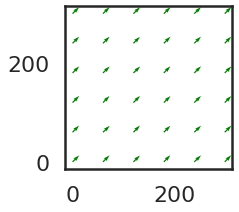

In [16]:
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from stable_baselines3 import A2C
env = oceangym.OceanScape()
from tqdm.auto import tqdm

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
******************************
self.wind_grid_shape=array([6, 6]), self.grid_width=50

!------- generated random wind ---!
self.wind_x_grid.shape=(6, 6)
self.wind_x_grid.shape=(6, 6)
self.xx.shape=(6, 6)

drwaing wind boundaries
done drawing elements on canvas


test progress bar:   0%|          | 0/1000 [00:00<?, ?it/s]

******************************
self.wind_grid_shape=array([6, 6]), self.grid_width=50

!------- generated random wind ---!
self.wind_x_grid.shape=(6, 6)
self.wind_x_grid.shape=(6, 6)
self.xx.shape=(6, 6)

drwaing wind boundaries
done drawing elements on canvas


test progress bar:  41%|████      | 407/1000 [00:05<00:08, 70.88it/s]

oops ran out of battery, final return -10
final position (0, 53)
******************************
self.wind_grid_shape=array([6, 6]), self.grid_width=50

!------- generated random wind ---!
self.wind_x_grid.shape=(6, 6)
self.wind_x_grid.shape=(6, 6)
self.xx.shape=(6, 6)

drwaing wind boundaries
done drawing elements on canvas


test progress bar:  73%|███████▎  | 733/1000 [00:10<00:04, 58.62it/s]

oops ran out of battery, final return -10
final position (0, 55)
******************************
self.wind_grid_shape=array([6, 6]), self.grid_width=50

!------- generated random wind ---!
self.wind_x_grid.shape=(6, 6)
self.wind_x_grid.shape=(6, 6)
self.xx.shape=(6, 6)

drwaing wind boundaries
done drawing elements on canvas


test progress bar: 100%|██████████| 1000/1000 [00:14<00:00, 69.81it/s]


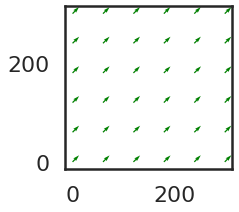

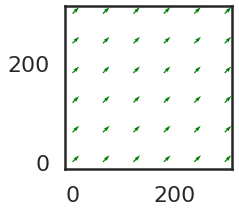

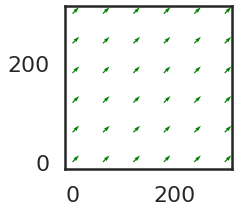

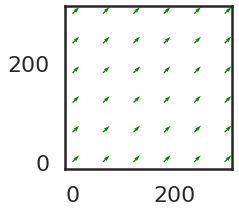

In [17]:
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=1)

obs = env.reset()
for i in tqdm(range(1000), desc='test progress bar'):
  action, _state = model.predict(obs, deterministic=True)
  obs, reward, done, info = env.step(action)
  env.render()
  if done:
    obs = env.reset()

## Remove render function from step()

Save final result as coordinates and render at end